In [1]:
import os

import mysql.connector
import pandas as pd

from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
start = datetime.now()
print("start = ", start)
try:
    
    mydb = mysql.connector.connect(
        host=os.environ['MYSQL_SPOTIFY_HOST'],
        user=os.environ['MYSQL_SPOTIFY_USER'],
        password=os.environ['MYSQL_SPOTIFY_PW'],
        database="wilts_songs"
    )

    mycursor = mydb.cursor()
    mycursor.execute("""SELECT * FROM songs;""")

    data = mycursor.fetchall()
except mysql.connector.Error as error:
    print("Failed to insert into MySQL table {}".format(error))

finally:
    if mydb.is_connected():
        mycursor.close()
        mydb.close()
        print("MySQL connection is closed")
    end = datetime.now()
    print("finish = ", end)
    print("duration = ", (end-start).total_seconds())

start =  2022-03-17 11:14:28.896898
MySQL connection is closed
finish =  2022-03-17 11:14:28.997910
duration =  0.101012


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
columns = ['id', 'track_name', 'artist_name', 'popularity', 'duration_ms',
        'danceability', 'time_signature', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo']

nominal_cols = ['id', 'track_name', 'artist_name']
discret_cols = ['key', 'mode']
continuous_cols = ['popularity', 'duration_ms', 'danceability', 'time_signature', 'loudness', 'speechiness',
        'instrumentalness', 'liveness', 'valence', 'tempo', 'acousticness*energy'] 
useful_cols = discret_cols + continuous_cols

In [5]:
df = pd.DataFrame(data, columns=columns)

In [6]:
df['acousticness*energy']=df['acousticness']*df['energy']

On retire les colonnes energy et acousticness des colonnes utilisées pour le modèle et on ajoute acousticness*energy vu les conclusions de l'analyse de la donnée.

In [7]:
df=df[useful_cols]

In [19]:
df.describe()

,key,mode,popularity,duration_ms,danceability,time_signature,loudness,speechiness,instrumentalness,liveness,valence,tempo,acousticness*energy
count,18209.000000,18209.000000,18209.000000,1.820900e+04,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000
mean,5.239167,0.705420,53.534681,2.349242e+05,0.570275,3.913065,-9.506448,0.071309,0.097785,0.198077,0.560166,120.248642,0.134408
std,3.521069,0.455866,19.853799,9.038462e+04,0.166637,0.371238,4.475365,0.079428,0.244145,0.173292,0.251719,28.945378,0.129817
min,0.000000,0.000000,0.000000,3.062200e+04,0.000000,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,47.000000,1.811330e+05,0.458000,4.000000,-11.930000,0.033000,0.000000,0.091800,0.362000,97.867000,0.020380
50%,5.000000,1.000000,57.000000,2.230790e+05,0.578000,4.000000,-8.755000,0.042200,0.000049,0.129000,0.569000,119.397000,0.101432
75%,8.000000,1.000000,67.000000,2.703330e+05,0.689000,4.000000,-6.275000,0.067500,0.009100,0.252000,0.771000,136.837000,0.215344
max,11.000000,1.000000,100.000000,1.644773e+06,0.988000,5.000000,0.899000,0.954000,1.000000,0.997000,0.993000,243.372000,0.877184


In [20]:
numeric_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

In [21]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, useful_cols),
])



In [32]:
from sklearn.cluster import AffinityPropagation, KMeans, Birch

randomf = Birch()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])



Choix modèle: https://scikit-learn.org/stable/modules/clustering.html  
Gridsearch avec unsupervised: https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning

In [4]:
from sklearn import metrics
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator['model'].labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels)

cv = [(slice(None), slice(None))]
# gs = GridSearchCV(estimator=sklearn.cluster.MeanShift(), param_grid=param_dict, 
#                   scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)
# gs.fit(df[cols_of_interest])

In [34]:

from sklearn.model_selection import GridSearchCV

param_dict_affinity = {'model__damping': [0.5], 'model__max_iter': [200]}
param_dict_kmeans = {'model__n_clusters': [50, 15, 20, 1], 'model__max_iter': [300]}
param_dict_birch = {'model__n_clusters': [None], 'model__branching_factor': [25, 50, 75, 100]}

search = GridSearchCV(randomf_pipeline, param_dict_birch, 
                      cv=cv, 
                      scoring=cv_silhouette_scorer)

_ = search.fit(df)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)



Best score: 0.5705312116938209
Best params: {'model__branching_factor': 50, 'model__n_clusters': None}


In [45]:
search.__dict__

{'scoring': <function __main__.cv_silhouette_scorer(estimator, X)>,
 'estimator': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('number',
                                                   Pipeline(steps=[('scale',
                                                                    MinMaxScaler())]),
                                                   ['key', 'mode', 'popularity',
                                                    'duration_ms',
                                                    'danceability',
                                                    'time_signature', 'loudness',
                                                    'speechiness',
                                                    'instrumentalness',
                                                    'liveness', 'valence',
                                                    'tempo',
                                                    'acousticness*energy'])])),
         

In [48]:
import numpy as np

Nombre de clusters : 

In [50]:
len(np.unique(search.predict(df)))

74

Enregistrer les résultats du modele sur mysql pour faire des suggestion à l'utilisateur ensuite ?   
Lire l'extrait sur l'app de la chanson comparée, et éventuellement des suggestions  
Collecter info sur app : satisfait ou non de la conclusion du bot pour éventuellement faire du ml pour la partie 2 plutôt que des stats 

In [53]:

import pickle
filename = 'birch5705+74.sav'
pickle.dump(search.best_estimator_, open(filename, 'wb'))



In [12]:
from pycaret.clustering import *
s = setup(df, normalize = True)

,Description,Value
0,session_id,646
1,Original Data,"(18209, 13)"
2,Missing Values,0
3,Numeric Features,10
4,Categorical Features,3
5,Ordinal Features,0
6,High Cardinality Features,0
7,High Cardinality Method,None
8,Transformed Data,"(18209, 29)"
9,CPU Jobs,-1


In [17]:
kmeans = create_model('birch', num_clusters=73)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0183,322.2728,2.4179,0,0,0


In [18]:
evaluate_model(kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Cluster PCA Plot (2d)', …

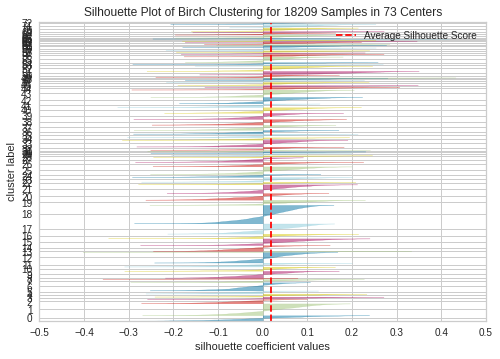

In [19]:
plot_model(kmeans, plot = 'silhouette')

https://pycaret.readthedocs.io/en/latest/api/clustering.html

https://www.kaggle.com/fk0728/feature-engineering-with-sklearn-pipelines

In [ ]:
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
>>> labels = kmeans_model.labels_
>>> metrics.silhouette_score(X, labels, metric='euclidean')

In [ ]:
model_pipeline = Pipeline(steps=[
  ("features", FeatureUnion([
    (
      "numerical_features",
      ColumnTransformer([
        (
          "numerical",
          Pipeline(steps=[(
            "impute_stage",
            SimpleImputer(missing_values=np.nan, strategy="median",)
          )]),
          ["feature_1"]
        )
      ])
    ), (
      "categorical_features",
      ColumnTransformer([
        (
          "country_encoding",
          Pipeline(steps=[
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
            ("reduction", NMF(n_components=8)),
          ]),
          ["country"],
        ),
      ])
    ), (
      "text_features",
      ColumnTransformer([
        (
          "title_vec",
          Pipeline(steps=[
            ("tfidf", TfidfVectorizer()),
            ("reduction", NMF(n_components=50)),
          ]),
          "title"
        )
      ])
    )
  ])),
  ("classifiers", RandomForestClassifier())
])

model_pipeline.fit(train_data, train_labels.values)
predictions = model_pipeline.predict(predict_data)


In [ ]:

def trans_func(input_series):
    return output_series

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(trans_func)

sk_pipe = Pipeline([("trans", transformer), ("vect", tf_1k), ("clf", clf_1k)])
sk_pipe.fit(train.desc, train.tag)

# where vect is a tf_idf transformer, 
# clf is a classifier and train is the training dataset. 
# "train.desc" is the series text input to the pipeline.

In [ ]:
def trans_func(input_series):
    return output_series

from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(trans_func)

In [ ]:
    
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

